<a href="https://colab.research.google.com/github/amitkp57/colab/blob/main/DL_Model_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset setup

In [ ]:
import os
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np

import timeit

import torch
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Function
from torch import nn
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")
plt.ion()

In [ ]:
PROJECT_DIR = '/content'
BATCH_SIZE = 32

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /content/cifar100_pytorch/cifar-100-python.tar.gz to /content/cifar100_pytorch
Files already downloaded and verified
10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


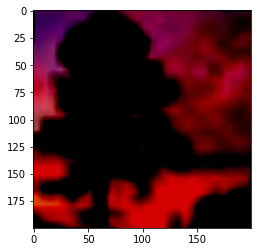

pine_tree


In [ ]:
# cifar100
transform_train = transforms.Compose([transforms.Resize((220, 220)),  
                                      transforms.RandomCrop((200, 200), padding=5, padding_mode = 'edge'),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(10),     
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])
 
transform_test = transforms.Compose([transforms.Resize((220, 220)),
                               transforms.CenterCrop(200),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

cifar100_train_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=True,
                                                    transform=transform_train, download=True)
cifar100_train_loader = torch.utils.data.DataLoader(cifar100_train_dset, batch_size=BATCH_SIZE, shuffle=False,
                                                    num_workers=0)

cifar100_test_dset = torchvision.datasets.CIFAR100(f'{PROJECT_DIR}/cifar100_pytorch', train=False,
                                                    transform=transform_test, download=True)
cifar100_test_loader = torch.utils.data.DataLoader(cifar100_test_dset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

pickleFile = open(f"{PROJECT_DIR}/cifar100_pytorch/cifar-100-python/meta", 'rb')
dic = pickle.load(pickleFile)
pickleFile.close()

classes = dic['fine_label_names']
print(len(cifar100_test_dset))


def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(cifar100_train_loader)
images, labels = dataiter.next()
rnd_idx = np.random.randint(BATCH_SIZE)

# show images
imshow(torchvision.utils.make_grid(images[rnd_idx], nrow=8))
# print labels
print(classes[labels[rnd_idx]])

### Model

In [ ]:
device = 'cuda:0'
EPOCHS = 5
num_classes = 100
model = models.resnet152(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 100)
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### Training (finetune the pretrained model)

In [ ]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1)

In [ ]:
for epoch in range(EPOCHS):
    total_corrects, total_datapoints = 0, 0
    start_time = timeit.default_timer()
    total_loss = 0.0

    model = model.train()

    ## training step
    for images, labels in cifar100_train_loader:
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()
        total_corrects += (torch.max(logits, 1)[1].view(labels.size()).data == labels.data).sum()
        total_datapoints += labels.shape[0]
        total_loss += loss.item()
    scheduler.step()
    end_time = timeit.default_timer()
    print('Epoch: %d | Train Loss: %.4f | Train Accuracy: %.4f | Time Taken: %d' \
          %(epoch, total_loss / len(cifar100_train_loader), total_corrects / total_datapoints, end_time-start_time))

### Test performance of the original model

In [ ]:
%%timeit -n 3 -r 1

test_acc = 0.0

model.eval()
total_corrects, total_datapoints = 0, 0
with torch.no_grad():
    for images, labels in cifar100_test_loader:
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        total_corrects += (torch.max(logits, 1)[1].view(labels.size()).data == labels.data).sum()
        total_datapoints += labels.shape[0]
accuracy = total_corrects / total_datapoints
print('Test Accuracy: %.4f'%(accuracy.item()))

### Test performance of modified model

In [ ]:
%%timeit -n 3 -r 1

import copy

test_acc = 0.0
model_f18 = copy.deepcopy(model).to(torch.float16).to(device)
model_f18.eval()
total_corrects, total_datapoints = 0, 0
with torch.no_grad():
    for images, labels in cifar100_test_loader:
        images = images.to(torch.float16).to(device)
        labels = labels.to(device)

        logits = model_f18(images)
        total_corrects += (torch.max(logits, 1)[1].view(labels.size()).data == labels.data).sum()
        total_datapoints += labels.shape[0]
accuracy = total_corrects / total_datapoints
print('Test Accuracy: %.4f'%(accuracy.item()))


In [ ]:
for param in model.parameters():
    print(param)

Streaming output truncated to the last 5000 lines.
        -1.1060e-01, -5.5846e-02, -8.4576e-02, -9.8384e-02, -5.7340e-02,
        -1.1147e-01, -9.9561e-02, -5.8988e-02, -6.0849e-02, -7.3668e-02,
        -1.0515e-01, -7.3890e-02, -5.2103e-02, -5.8667e-02, -9.4814e-02,
        -4.1146e-02, -5.2921e-02, -8.7525e-02, -7.2136e-02, -7.6786e-02,
        -7.2740e-02, -9.3102e-02, -2.1764e-02, -1.2541e-01, -9.2303e-02,
        -5.2880e-02,  2.1895e-02, -9.0285e-02, -8.4805e-02, -6.6422e-02,
        -6.2981e-02, -7.9917e-02, -9.9537e-02, -9.8104e-02, -7.9306e-02,
        -7.4400e-02, -1.0606e-01, -2.6838e-02, -6.0416e-02, -6.2896e-02,
        -7.1558e-02, -8.1741e-02, -1.0187e-01, -3.0528e-02, -7.2673e-02,
        -7.5791e-02, -7.0864e-02, -1.1012e-01, -6.6804e-02, -6.4878e-02,
        -8.3257e-02,  4.7223e-03, -9.4550e-02, -6.3152e-02, -2.6737e-02,
        -5.3719e-02, -2.6953e-02, -1.0752e-01,  3.3709e-02, -6.7472e-02,
        -8.2041e-02, -1.3256e-01, -7.2420e-02, -9.9278e-02, -6.3935e-02,
